<a href="https://colab.research.google.com/github/GaetanAm/Sentiment-Analysis-and-Impact-on-Financial-Markets/blob/main/notebooks/Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stage 1: Machine Learning Project Notebook**

## **1. Introduction**
This notebook focuses on analyzing the impact of financial sentiments (from news articles and tweets) on stock price movements.

The goal is to evaluate whether sentiment trends can predict price changes and their strength.

In [159]:
# Required Libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import snscrape.modules.twitter as sntwitter
from datetime import datetime, timedelta
from google.colab import files
from huggingface_hub import login
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from transformers import pipeline
from google.colab import userdata



# Installer et importer yfinance pour récupérer les données boursières
import yfinance as yf


## **2. Problem Formalization and ML Tasks**
Objective:
- Predict stock price movement based on sentiment analysis of financial news and tweets.

ML Tasks:
- Sentiment Classification.
- Correlation and Regression Analysis.

Models Chosen:
- Twitter-roBERTa-base for tweets.
- FinBERT for structured financial news.
- Regression models to correlate sentiment scores with stock price changes.

## **3. Creation of the datasets**

### TWEETS DATASET

In [143]:
# API key and configuration
consumer_key_X = userdata.get('X_CONSUMER_KEY')
consumer_secret_X = userdata.get('X_CONSUMER_SEC')
access_token_X = userdata.get('X_TOKEN_ACCESS')
access_token_secret_X = userdata.get('X_TOKEN_SECRET')

# Authenticate with Twitter
auth = tweepy.OAuthHandler(consumer_key_X, consumer_secret_X)
auth.set_access_token(access_token_X, access_token_secret_X)
api = tweepy.API(auth)

# Example
tweets = api.search_tweets(q="Apple OR AAPL", lang="en", count=5)
for tweet in tweets:
    print(tweet.text)

Forbidden: 403 Forbidden
453 - You currently have access to a subset of X API V2 endpoints and limited v1.1 endpoints (e.g. media post, oauth) only. If you need access to this endpoint, you may need a different access level. You can learn more here: https://developer.x.com/en/portal/product

In [141]:
# Twitter API v2 key
bearer_token = userdata.get('X_BEARER_TOKEN')

# Create a client using Twitter API v2
client = tweepy.Client(bearer_token=bearer_token)

# Search recent tweets
query = "Apple OR AAPL lang:en"
tweets = client.search_recent_tweets(query=query, max_results=10)

for tweet in tweets.data:
    print(tweet.text)

RT @TomJumboGrumbo: A puppy who only became available for adoption on Dec 18, Ebenezer #247668 is now at risk TBK in Apple Valley CA. Just…
apple tv PLS im gonna cry https://t.co/ijVCUXFX7c
RT @treblewoe: Since Silicon Valley hiring has everyone’s attention, here’s the experience of someone who was a hiring manager for over a d…
It’s really amazing Place,
Lot of thanks to this community...👇 
https://t.co/WUfz59GZw8

$TCEHY $RKT $FB $UBER $AYX $DDOG $BABA $BNGO $AAPL $TSLA https://t.co/LsJULaRyCG
@Lordmangu @ira_mae0204 Can I cashapp you or Apple Pay you sum if yes drop your cashapp tag..... I’m fr
RT @akiko_lawson: ＼ローソン × Mrs. GREEN APPLE／
キャンペーン開催記念！
@akiko_lawsonをフォローし「#ローソン_MGA」とコメントを入れて引用ポスト♪
抽選で1名様にQUOカード1万円分が当たります(^^)
#ローソン #Mr…
This little scumbag CIA agent of a president is the worst human being on the planet Earth. Hold the alien hostage. Sell state secrets. Wreck the United States of America. The Nazi apple didn't fall far from the tree. https://t.co/eRWoAUcB8a
@Apple_Dog_So




---


**Apparently, the Tweepy library no longer works as expected due to the removal of free access to the Twitter API.**

An alternative using Twitter API v2 initially worked, but we encountered severe limitations due to request rate restrictions.

Ultimately, this resulted in the following error:

> TooManyRequests: 429 Too Many Requests.


---


In [142]:
# Set up query and list to store tweets
query = "Apple OR AAPL lang:en"
tweets = []

# Collect tweets with snscrape
for tweet in sntwitter.TwitterSearchScraper(f"{query}").get_items():
    if len(tweets) >= 10:  # Limit the number of tweets to collect
        break
    tweets.append(tweet.content)

# Display collected tweets
for tweet in tweets:
    print(tweet)

ERROR:snscrape.base:Error retrieving https://twitter.com/search?f=live&lang=en&q=Apple+OR+AAPL+lang%3Aen&src=spelling_expansion_revert_click: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=Apple+OR+AAPL+lang%3Aen&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"))
CRITICAL:snscrape.base:4 requests to https://twitter.com/search?f=live&lang=en&q=Apple+OR+AAPL+lang%3Aen&src=spelling_expansion_revert_click failed, giving up.
CRITICAL:snscrape.base:Errors: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=Apple+OR+AAPL+lang%3Aen&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable 

ScraperException: 4 requests to https://twitter.com/search?f=live&lang=en&q=Apple+OR+AAPL+lang%3Aen&src=spelling_expansion_revert_click failed, giving up.



---


**As a result, we decided to explore `snscrape` as another alternative for collecting tweets. However, this approach also has its own limitations.**

Specifically, we encountered the following error when attempting to scrape tweets:


> ScraperException: 4 requests to https://twitter.com/search?f=live&lang=en&q=Apple+OR+AAPL+lang%3Aen&src=spelling_expansion_revert_click failed, giving up.

This suggests that Twitter may have introduced restrictions or other mechanisms that limit scraping functionality.

Further adjustments or alternative methods may be required to overcome these challenges.



---



**Given these challenges, we have temporarily abandoned the creation of the tweet database.**

**Instead, we will focus on collecting newspaper headlines for the next phase of our project.**


---



### NEWSPAPER HEADLINES DATASET

We tried collecting newspaper headlines using yfinance.
However, we encountered the following limitations:
1. Only certain articles are accessible.
2. The free plan restricts access to articles from only the past month.

As a result, we will need to explore alternative methods or data sources to collect sufficient financial news data.


---



In [130]:
# Récupérer les titres d'actualités pour Tesla
tesla_test = yf.Ticker("TSLA")
news_test = tesla_test.news

# Afficher les titres
for item in news_test:
    print(item['title'])

Is Tesla Stock A Buy Or A Sell With 70% Trump Surge A 'Sharp Disconnect' From Fundamentals?
Magnificent Seven Stocks: Nvidia, Tesla Tumble; Apple, Google, Meta Sell Off
Tesla's Musk Uses Weight-Loss Drugs as Eli Lilly and Novo Nordisk Dominate the Market
Why the Tesla Stock Rally Is Fading Today
2025 is the year Tesla leaders need to deliver: Investor
The Dow sinks 500 points as Nvidia and Tesla lead tech decline
Tesla Stock Falls for a Second Day. Why Shares Are Limping Into Year End.
Analyst: Tesla (TSLA) Will Benefit in ‘Tough’ Environment for EV Companies Under Trump Administration


In [131]:
# Créer un DataFrame avec les titres
tesla_news_test = pd.DataFrame(news_test)
tesla_news_test = tesla_news_test[['title', 'providerPublishTime']]
tesla_news_test['providerPublishTime'] = pd.to_datetime(tesla_news_test['providerPublishTime'], unit='s').dt.date

# Filtrer les titres qui mentionnent Tesla explicitement
tesla_news_test = tesla_news_test[tesla_news_test['title'].str.contains("Tesla", case=False)]
print(tesla_news_test.head())

                                               title providerPublishTime
0  Is Tesla Stock A Buy Or A Sell With 70% Trump ...          2024-12-27
1  Magnificent Seven Stocks: Nvidia, Tesla Tumble...          2024-12-27
2  Tesla's Musk Uses Weight-Loss Drugs as Eli Lil...          2024-12-27
3          Why the Tesla Stock Rally Is Fading Today          2024-12-27
4  2025 is the year Tesla leaders need to deliver...          2024-12-27




---


After encountering limitations with yfinance, we turned to News API for collecting financial headlines.

Due to the API's restriction on the number of articles retrievable per API key, we devised the following solution:
1. Created multiple API keys to bypass the daily quota limitation.
2. Set up a system to fetch all articles every 3 hours within the target period (from 2024-11-07 to 2024-12-07).

**This approach allowed us to gather a more comprehensive dataset over the specified timeframe despite the API's limitations.**


---




In [134]:
# Clé API et configuration
API_KEY = userdata.get('NEWS_API_KEY')
URL = "https://newsapi.org/v2/everything"

# Période cible
start_date = datetime(2024, 12, 4)
end_date = datetime(2024, 12, 7)

# Fonction pour récupérer les articles
def fetch_articles(start, end):
    articles = []
    params = {
        "q": "Tesla",
        "from": start.strftime("%Y-%m-%dT%H:%M:%S"),
        "to": end.strftime("%Y-%m-%dT%H:%M:%S"),
        "language": "en",
        "sortBy": "relevancy",
        "apiKey": API_KEY,
        "pageSize": 100,
        "page": 1
    }
    while True:
        response = requests.get(URL, params=params)
        data = response.json()
        if response.status_code != 200:
            print(f"Erreur : {data.get('message')}")
            break
        articles.extend(data.get("articles", []))
        if len(data.get("articles", [])) < 100:  # Si moins de 100 articles, pas de page suivante
            break
        params["page"] += 1  # Passer à la page suivante
    return articles

# Itérer sur des intervalles de 3 heures
all_articles = []
current_date = start_date
while current_date < end_date:
    next_date = current_date + timedelta(hours=3)  # Timeline de 3 heures
    if next_date > end_date:
        next_date = end_date
    print(f"Récupération des articles du {current_date} au {next_date}")
    all_articles.extend(fetch_articles(current_date, next_date))
    current_date = next_date  # Passer au prochain intervalle

# Convertir les résultats en DataFrame
tesla_news = pd.DataFrame(all_articles)
tesla_news = tesla_news[['title', 'publishedAt']]
tesla_news['publishedAt'] = pd.to_datetime(tesla_news['publishedAt']).dt.date
tesla_news = tesla_news.drop_duplicates(subset=['title'])  # Supprimer les doublons
print(f"Nombre total d'articles récupérés : {len(tesla_news)}")
print(tesla_news.head())

Récupération des articles du 2024-12-04 00:00:00 au 2024-12-04 03:00:00
Récupération des articles du 2024-12-04 03:00:00 au 2024-12-04 06:00:00
Récupération des articles du 2024-12-04 06:00:00 au 2024-12-04 09:00:00
Récupération des articles du 2024-12-04 09:00:00 au 2024-12-04 12:00:00
Récupération des articles du 2024-12-04 12:00:00 au 2024-12-04 15:00:00
Récupération des articles du 2024-12-04 15:00:00 au 2024-12-04 18:00:00
Récupération des articles du 2024-12-04 18:00:00 au 2024-12-04 21:00:00
Récupération des articles du 2024-12-04 21:00:00 au 2024-12-05 00:00:00
Erreur : You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.
Récupération des articles du 2024-12-05 00:00:00 au 2024-12-05 03:00:00
Récupération des articles du 2024-12-05 03:00:00 au 2024-12-05 06:00:00
Récupération des articles du 2024-12-05 06:00:00 au 2024-12-05 09:00:00
Récu



---


During the data collection process with News API, we noticed a significant surge in the number of articles retrieved between 00:00 and 03:00 each day. This likely corresponds to the automatic publication schedules of news websites.

Due to these surges, the API often returned the error:

> You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.

**This issue underscores the challenges of collecting data within the constraints of a free API plan, particularly when dealing with spikes in content generation at specific times of the day.**


---



In [ ]:
# Sauvegarder les titres et les sentiments dans un fichier CSV
tesla_news.to_csv('tesla_news.csv', index=False)

# OU

# Ajouter les nouvelles données au fichier CSV existant
tesla_news.to_csv('tesla_news.csv', mode='a', index=False, header=False)

In [ ]:
files.download('tesla_news.csv')

In [82]:
# Téléchargement du fichier CSV contenant les données des articles
uploaded = files.upload()

Saving tesla_news.csv to tesla_news (1).csv


In [137]:
login(userdata.get('LOGIN_HF'))
# Charger le fichier CSV
file_path = "tesla_news.csv"  # Remplacez par le chemin vers votre fichier
tesla_news = pd.read_csv(file_path)

# Afficher un aperçu des données
print(tesla_news.head())
# Charger FinBERT
sentiment_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")
def analyze_sentiment(text):
    try:
        return sentiment_pipeline(inputs=text)[0]['label']  # Utiliser "inputs" si "text" ne fonctionne pas
    except Exception as e:
        print(f"Erreur avec le texte : {text} -> {e}")
        return "Error"
# Appliquer l'analyse des sentiments à tous les titres
tesla_news['sentiment'] = tesla_news['title'].apply(analyze_sentiment)

# Afficher un aperçu des résultats
print(tesla_news[['title', 'sentiment']].head())

                                               title publishedAt sentiment
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07  Positive
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07  Positive
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07  Negative
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07  Positive
4                                          [Removed]  2024-11-07   Neutral


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Device set to use cpu


Erreur avec le texte : nan -> text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
                                               title sentiment
0  Tesla police cruiser, Trump voters love solar,...  Positive
1  Dow Jones Surges On Trump Win. What To Do As S...  Positive
2  Trump Lackey Elon Musk's Biggest Controversies...  Negative
3  How Elon Musk’s $130 million investment in Tru...  Positive
4                                          [Removed]   Neutral


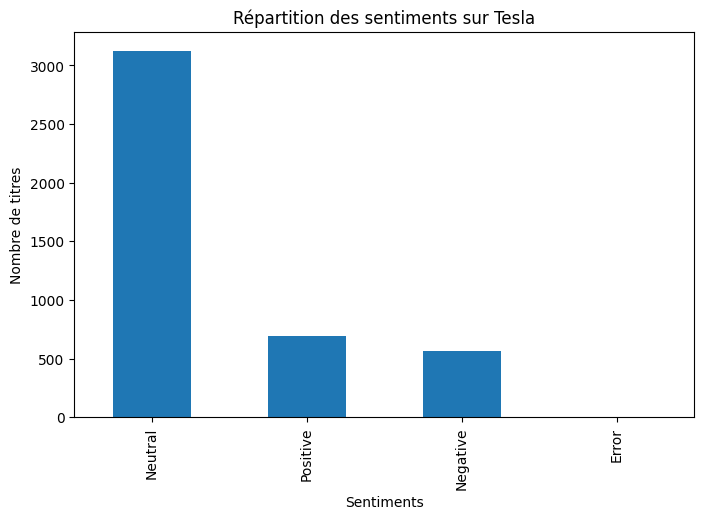

In [138]:
# Répartition des sentiments
tesla_news['sentiment'].value_counts().plot(kind='bar', title='Répartition des sentiments sur Tesla', figsize=(8, 5))
plt.xlabel('Sentiments')
plt.ylabel('Nombre de titres')
plt.show()

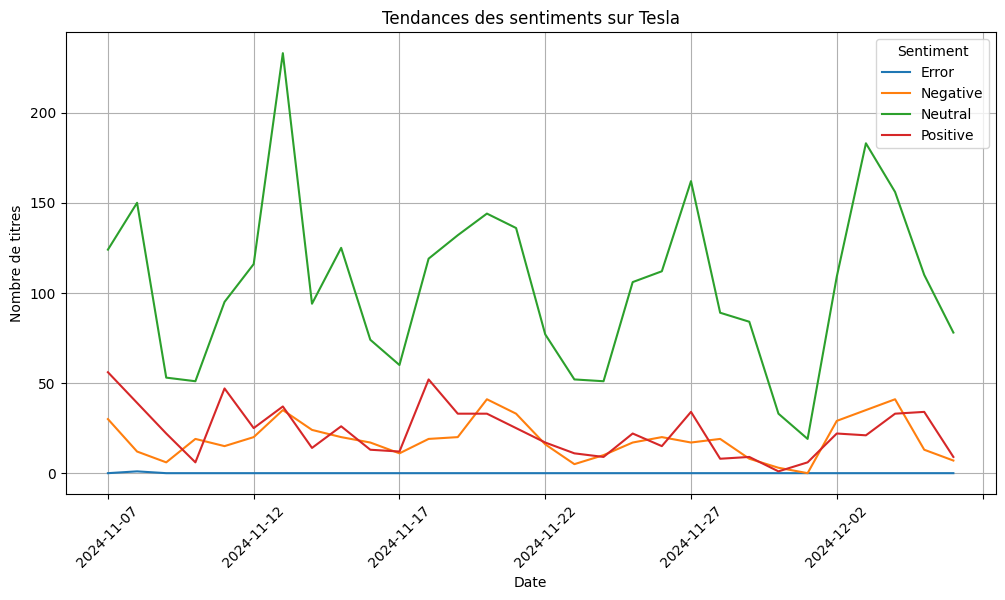

In [139]:
sentiment_trend = tesla_news.groupby(['publishedAt', 'sentiment']).size().unstack(fill_value=0)

# Tracer les tendances
sentiment_trend.plot(kind='line', figsize=(12, 6), title='Tendances des sentiments sur Tesla')
plt.xlabel('Date')
plt.ylabel('Nombre de titres')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()



---


- We observe a significantly higher number of articles classified as **neutral** compared to the other sentiment categories. This dominance remains consistent throughout the analyzed period.
- Articles classified as **positive** and **negative** have similar volumes and appear to follow relatively stable trends over time.
- In terms of temporal evolution, only the number of **neutral** articles shows noticeable variations, with significant peaks on specific dates. In contrast, the volumes of **positive** and **negative** articles remain fairly constant over time, without major fluctuations.

**This suggests that most articles about Tesla tend to be factual or report information without strong emotional bias. Meanwhile, both positive and negative opinions on Tesla are published at a steady and consistent rate.**


---



## **4. Data Description and Exploration (EDA)**

In [145]:
# Chargement des données avec pandas
file_path = "tesla_news.csv"  # Chemin du fichier CSV

# Lecture du fichier CSV
df = pd.read_csv(file_path)

# Aperçu des premières lignes des données et vérification de la structure
print(df.head())  # Affiche les 5 premières lignes
print(df.info())  # Donne des informations sur le type des colonnes et les valeurs manquantes

                                               title publishedAt sentiment
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07  Positive
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07  Positive
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07  Negative
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07  Positive
4                                          [Removed]  2024-11-07   Neutral
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4381 entries, 0 to 4380
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4380 non-null   object
 1   publishedAt  4381 non-null   object
 2   sentiment    4381 non-null   object
dtypes: object(3)
memory usage: 102.8+ KB
None


Les colonnes contiennent :
- **title** : le titre de l'article, texte non structué.
- **publishedAt** : la date de publication, au format objet.
- **sentiment** : sentiment associé (Positive, Neutral, Negative).


In [149]:
# Récupération des données historiques pour l'action Tesla
tesla = yf.Ticker("TSLA")
stock_data = tesla.history(start="2024-11-07", end="2024-12-06")

# Filtrage pour ne garder que le prix de clôture
stock_data = stock_data[["Close"]]
stock_data.reset_index(inplace=True)
stock_data.rename(columns={"Date": "publishedAt", "Close": "stock_price"}, inplace=True)
print(stock_data.head())

                publishedAt  stock_price
0 2024-11-07 00:00:00-05:00   296.910004
1 2024-11-08 00:00:00-05:00   321.220001
2 2024-11-11 00:00:00-05:00   350.000000
3 2024-11-12 00:00:00-05:00   328.489990
4 2024-11-13 00:00:00-05:00   330.239990


La plage de dates du 7 novembre 2024 au 6 décembre 2024 a été choisie car elle correspond à la période de publication des articles dans le fichier « tesla_news.csv ».


In [153]:
# Conversion des dates pour aligner les deux datasets
df['publishedAt'] = pd.to_datetime(df['publishedAt']).dt.tz_localize(None)
stock_data['publishedAt'] = pd.to_datetime(stock_data['publishedAt']).dt.tz_localize(None)

print(df['publishedAt'].dtype)
print(stock_data['publishedAt'].dtype)

# Fusion des deux jeux de données sur la colonne "publishedAt"
merged_data = pd.merge(df, stock_data, on='publishedAt', how='inner')
print(merged_data.head())

datetime64[ns]
datetime64[ns]
                                               title publishedAt sentiment  \
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07  Positive   
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07  Positive   
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07  Negative   
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07  Positive   
4                                          [Removed]  2024-11-07   Neutral   

   stock_price  
0   296.910004  
1   296.910004  
2   296.910004  
3   296.910004  
4   296.910004  




---


La méthode "inner" est utilisée pour ne conserver que les lignes où les dates sont présentes dans les deux jeux de données. Cela garantit une correspondance stricte entre les sentiments et les prix des actions disponibles, réduisant le bruit potentiel dans l'analyse.


---



In [154]:
# Encodage des sentiments pour qu'ils soient utilisables par les modèles
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
merged_data['sentiment'] = merged_data['sentiment'].map(sentiment_map)
print(merged_data.head())

                                               title publishedAt  sentiment  \
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07        1.0   
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07        1.0   
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07       -1.0   
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07        1.0   
4                                          [Removed]  2024-11-07        0.0   

   stock_price  
0   296.910004  
1   296.910004  
2   296.910004  
3   296.910004  
4   296.910004  


In [157]:
# Ajouter sentiment et stock_price dans un DataFrame
data_for_corr = merged_data[['sentiment', 'stock_price']]

# Calcul de la corrélation
correlation = data_for_corr.corr()
print(correlation)

             sentiment  stock_price
sentiment     1.000000    -0.025003
stock_price  -0.025003     1.000000


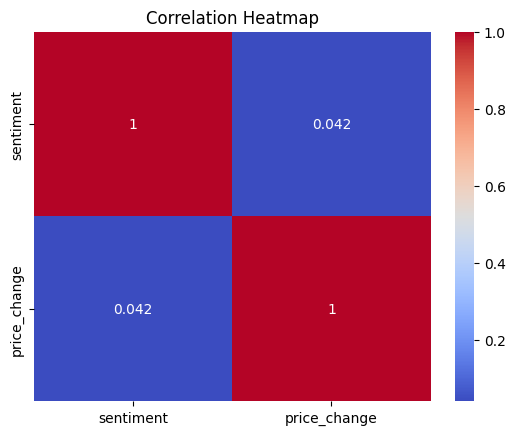

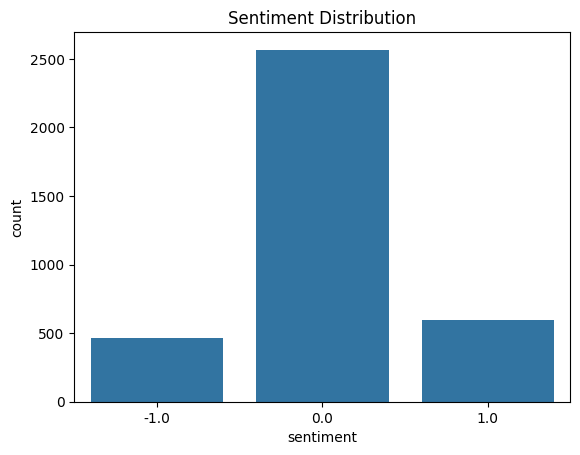

In [156]:
# Exploratory plots
sns.heatmap(data_for_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

sns.countplot(data=merged_data, x="sentiment")
plt.title("Sentiment Distribution")
plt.show()



---


La corrélation mesure la relation linéaire entre deux variables. Une corrélation proche de 0 entre "sentiment" et "stock_price" indique qu'il n'y a pas de relation linéaire évidente entre ces deux variables. Cela suggère que les sentiments des articles n'influencent pas directement les prix des actions Tesla.

Les variations de prix (différences entre les jours consécutifs) permettent d'analyser les changements quotidiens du prix de l'action Tesla, plutôt que les valeurs absolues. Cette approche peut révéler des relations subtiles entre les sentiments et les mouvements de marché qui ne seraient pas visibles dans une simple analyse des prix bruts.


---



In [87]:
# Séparation des données en variables explicatives (X) et variable cible (y)
from sklearn.model_selection import train_test_split

X = merged_data[['sentiment']]  # Variable explicative
y = merged_data['stock_price']  # Variable cible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(merged_data.head())

                                               title publishedAt  sentiment  \
0  Tesla police cruiser, Trump voters love solar,...  2024-11-07        1.0   
1  Dow Jones Surges On Trump Win. What To Do As S...  2024-11-07        1.0   
2  Trump Lackey Elon Musk's Biggest Controversies...  2024-11-07       -1.0   
3  How Elon Musk’s $130 million investment in Tru...  2024-11-07        1.0   
4                                          [Removed]  2024-11-07        0.0   

   stock_price  
0   296.910004  
1   296.910004  
2   296.910004  
3   296.910004  
4   296.910004  


In [88]:
print(merged_data['sentiment'].unique())

[ 1. -1.  0. nan]


In [89]:
# Vérification des valeurs manquantes dans X_test
print(X_test.isnull().sum())  # Compte des NaN par colonne
print(X_test[X_test.isnull().any(axis=1)])  # Lignes contenant des NaN

sentiment    1
dtype: int64
     sentiment
315        NaN


In [90]:
X_test = X_test.dropna()
y_test = y_test[X_test.index]  # Ajuster y_test pour correspondre aux indices mis à jour

print(X_test.isnull().sum())

sentiment    0
dtype: int64


## **5. Model Implementation**

### Modélisation avec une régression linéaire

In [161]:
# Entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 292.4435299996879
R^2 Score: -0.001134833974736127


Le Mean Squared Error (MSE) représente la moyenne des carrés des erreurs entre les valeurs réelles et prédites. Il mesure l'écart moyen au carré entre les prédictions du modèle et les valeurs réelles. Plus le MSE est faible, meilleure est la qualité des prédictions. Ici il est très élevé ce qui nous indique que la prédiction est quasi inexistante.

Le score R² est une mesure de la proportion de la variance dans la variable cible qui est expliquée par les variables explicatives. Un score faible (négatif ou proche de zéro) indique que le modèle explique très peu les variations des prix des actions Tesla en fonction des sentiments, ce qui suggère une faible prédictibilité basée uniquement sur ces données, ce qui est le cas ici.


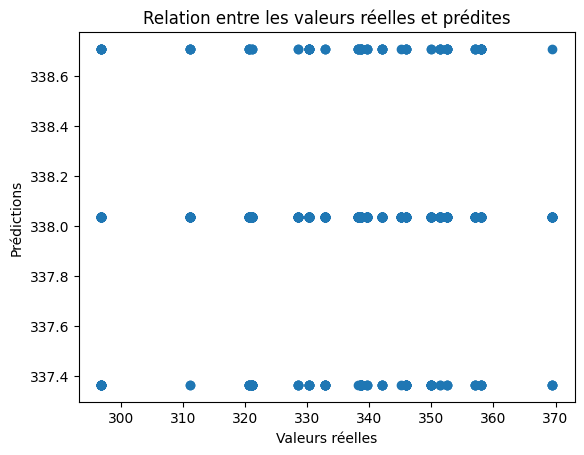

In [162]:
# Visualisation des prédictions vs valeurs réelles

plt.scatter(y_test, y_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Relation entre les valeurs réelles et prédites")
plt.show()

In [93]:
# Modèle Random Forest
# Entraîner un modèle Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions et évaluation pour Random Forest
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest MSE: 292.4204019931662
Random Forest R^2 Score: -0.0010556588499890385


In [95]:
# Calcul des variations de prix pour mieux comprendre l'impact des sentiments
merged_data['price_change'] = merged_data['stock_price'].diff().fillna(0)

# Corrélation entre sentiments et variations
data_for_corr = merged_data[['sentiment', 'price_change']]
correlation = data_for_corr.corr()
print(correlation)

              sentiment  price_change
sentiment      1.000000      0.041904
price_change   0.041904      1.000000


La corrélation avec les variations est également très faible ce qui suggère qu'on ne peut pas utiliser la base de données tel quel.

En filtrant les sentiments neutres, nous réduisons l'effet des données qui n'ont pas de contribution claire à la variabilité des prix des actions. Ce filtrage permet de se concentrer sur les relations entre les sentiments clairement positifs ou négatifs et les mouvements des prix, ce qui pourrait améliorer la corrélation et permettre une interprétation plus précise des résultats des modèles.


### Vérification de la stratégie basée uniquement sur les sentiments positifs/négatifs

In [96]:
# Filtrage des articles neutres pour voir l'effet des sentiments positifs/négatifs
filtered_data = merged_data[merged_data['sentiment'] != 0]

# Vérifier les nouvelles dimensions des données
print("Taille après filtrage :", filtered_data.shape)
print(filtered_data['sentiment'].value_counts())


Taille après filtrage : (1060, 5)
sentiment
 1.0    594
-1.0    465
Name: count, dtype: int64


In [109]:
# Corrélation sur les données filtrées
data_for_corr_filtered = filtered_data[['sentiment', 'stock_price']]
correlation_filtered = data_for_corr_filtered.corr()
print(correlation_filtered)


             sentiment  stock_price
sentiment     1.000000    -0.041215
stock_price  -0.041215     1.000000


In [98]:
# Redéfinir X et y
X_filtered = filtered_data[['sentiment']]
y_filtered = filtered_data['stock_price']

from sklearn.model_selection import train_test_split
X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

print("Taille de X_filtered_train :", X_filtered_train.shape)
print("Taille de y_filtered_train :", y_filtered_train.shape)


Taille de X_filtered_train : (848, 1)
Taille de y_filtered_train : (848,)


In [99]:
print(filtered_data['sentiment'].unique())

[ 1. -1. nan]


In [100]:
X_filtered_train = X_filtered_train.dropna()
y_filtered_train = y_filtered_train[X_filtered_train.index]  # Ajuster y_train pour correspondre à X_train
print(X_filtered_train.isnull().sum())  # Doit afficher 0

sentiment    0
dtype: int64


In [101]:
# Entraîner le modèle
model = LinearRegression()
model.fit(X_filtered_train, y_filtered_train)

# Prédictions
y_filtered_pred = model.predict(X_filtered_test)

# Évaluation
mse_filtered = mean_squared_error(y_filtered_test, y_filtered_pred)
r2_filtered = r2_score(y_filtered_test, y_filtered_pred)

print(f"Mean Squared Error: {mse_filtered}")
print(f"R^2 Score: {r2_filtered}")


Mean Squared Error: 353.237391344725
R^2 Score: -0.013829281090233625


In [102]:
# Comparaison des résultats avec et sans données neutres
print("Résultats sans filtrage des données neutres :")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print("\nRésultats avec filtrage des données neutres :")
print(f"Filtered Mean Squared Error: {mse_filtered}")
print(f"Filtered R^2 Score: {r2_filtered}")

Résultats sans filtrage des données neutres :
Mean Squared Error: 292.4435299996879
R^2 Score: -0.001134833974736127

Résultats avec filtrage des données neutres :
Filtered Mean Squared Error: 353.237391344725
Filtered R^2 Score: -0.013829281090233625


Les résultats montrent que ni le filtrage des données neutres ni l'inclusion de toutes les données n'améliorent significativement les performances du modèle. Voici une interprétation et une orientation future :

1. **Résultats observés** :
   - Le score R² reste négatif ou proche de zéro dans les deux cas, indiquant que les sentiments extraits ne permettent pas d'expliquer ou de prédire efficacement les prix ou les variations de prix des actions Tesla.
   - L'augmentation du MSE après le filtrage suggère que l'exclusion des sentiments neutres ne réduit pas l'erreur globale mais peut accentuer le bruit ou les écarts résiduels dans les prédictions.

2. **Implications** :
   - Ces résultats montrent une absence de relation claire entre les sentiments textuels et les prix des actions sur cette période donnée ou avec ce type de données.
   - Il est probable que d'autres facteurs influencent les prix, tels que des données financières spécifiques, des événements économiques globaux ou des indicateurs techniques.

### Vérification de la stratégie basée sur la moyenne par jour

In [103]:
# Calcul de la moyenne des sentiments par jour
daily_sentiment = filtered_data.groupby('publishedAt')['sentiment'].mean().reset_index()

# Joindre avec les prix journaliers
daily_data = pd.merge(daily_sentiment, merged_data[['publishedAt', 'stock_price']].drop_duplicates(), on='publishedAt', how='inner')

# Vérifier les données
print(daily_data.head())

  publishedAt  sentiment  stock_price
0  2024-11-07   0.302326   296.910004
1  2024-11-08   0.529412   321.220001
2  2024-11-11   0.516129   350.000000
3  2024-11-12   0.111111   328.489990
4  2024-11-13   0.027778   330.239990


In [104]:
# Calcul de la corrélation
corr_daily = daily_data[['sentiment', 'stock_price']].corr()
print(corr_daily)

             sentiment  stock_price
sentiment     1.000000    -0.068429
stock_price  -0.068429     1.000000


In [105]:
# Redéfinir X et y
X_daily = daily_data[['sentiment']]
y_daily = daily_data['stock_price']

# Diviser les données
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)

# Entraîner un modèle de régression
model_daily = LinearRegression()
model_daily.fit(X_train_daily, y_train_daily)

# Prédictions et évaluation
y_pred_daily = model_daily.predict(X_test_daily)
mse_daily = mean_squared_error(y_test_daily, y_pred_daily)
r2_daily = r2_score(y_test_daily, y_pred_daily)

print(f"Mean Squared Error (Daily): {mse_daily}")
print(f"R^2 Score (Daily): {r2_daily}")

Mean Squared Error (Daily): 814.2443143585264
R^2 Score (Daily): -0.7570303743632436


Le score R² reste négatif, cela confirme que la relation entre les sentiments des titres et les prix des actions est inexistante ou trop complexe pour être capturée par un simple modèle.

De plus la corrélation reste faible après agrégation, cela pourrait signifier que les sentiments textuels ne suffisent pas à eux seuls pour expliquer les variations des prix.

### Vérification de la stratégie en ajoutant le nombre d'articles positifs et négatifs par jour puis en incluant les neutres

In [106]:
# Compter les articles positifs et négatifs par jour
daily_sentiment_count = filtered_data.groupby('publishedAt')['sentiment'].value_counts().unstack(fill_value=0).reset_index()

# Renommer les colonnes pour plus de clarté
daily_sentiment_count.rename(columns={1.0: 'positive_count', -1.0: 'negative_count'}, inplace=True)

# Vérifier les données
print(daily_sentiment_count.head())

sentiment publishedAt  negative_count  positive_count
0          2024-11-07              30              56
1          2024-11-08              12              39
2          2024-11-11              15              47
3          2024-11-12              20              25
4          2024-11-13              35              37


In [107]:
# Joindre les comptes avec les prix des actions
daily_data_enriched = pd.merge(daily_sentiment_count, merged_data[['publishedAt', 'stock_price']].drop_duplicates(), on='publishedAt', how='inner')

# Vérifier les données
print(daily_data_enriched.head())

  publishedAt  negative_count  positive_count  stock_price
0  2024-11-07              30              56   296.910004
1  2024-11-08              12              39   321.220001
2  2024-11-11              15              47   350.000000
3  2024-11-12              20              25   328.489990
4  2024-11-13              35              37   330.239990


In [108]:
# Corrélation avec les nouvelles variables
correlation_enriched = daily_data_enriched[['positive_count', 'negative_count', 'stock_price']].corr()
print(correlation_enriched)

                positive_count  negative_count  stock_price
positive_count        1.000000        0.121827    -0.227880
negative_count        0.121827        1.000000    -0.013309
stock_price          -0.227880       -0.013309     1.000000


In [110]:
# Redéfinir X et y
X_enriched = daily_data_enriched[['positive_count', 'negative_count']]
y_enriched = daily_data_enriched['stock_price']

# Diviser les données en ensemble d'entraînement et de test
X_train_enriched, X_test_enriched, y_train_enriched, y_test_enriched = train_test_split(X_enriched, y_enriched, test_size=0.2, random_state=42)

# Entraîner un modèle de régression linéaire
model_enriched = LinearRegression()
model_enriched.fit(X_train_enriched, y_train_enriched)

# Prédictions et évaluation
y_pred_enriched = model_enriched.predict(X_test_enriched)
mse_enriched = mean_squared_error(y_test_enriched, y_pred_enriched)
r2_enriched = r2_score(y_test_enriched, y_pred_enriched)

print(f"Mean Squared Error (Enriched): {mse_enriched}")
print(f"R^2 Score (Enriched): {r2_enriched}")

Mean Squared Error (Enriched): 911.1878228351039
R^2 Score (Enriched): -0.9662215053137593


In [111]:
# Calcul des variations des prix
daily_data_enriched['price_change'] = daily_data_enriched['stock_price'].diff().fillna(0)

# Réutiliser le modèle pour prédire les variations
X_price_change = daily_data_enriched[['positive_count', 'negative_count']]
y_price_change = daily_data_enriched['price_change']

X_train_change, X_test_change, y_train_change, y_test_change = train_test_split(X_price_change, y_price_change, test_size=0.2, random_state=42)

# Modèle de régression
model_change = LinearRegression()
model_change.fit(X_train_change, y_train_change)

# Évaluation
y_pred_change = model_change.predict(X_test_change)
mse_change = mean_squared_error(y_test_change, y_pred_change)
r2_change = r2_score(y_test_change, y_pred_change)

print(f"Mean Squared Error (Change): {mse_change}")
print(f"R^2 Score (Change): {r2_change}")

Mean Squared Error (Change): 237.38893462105057
R^2 Score (Change): -0.7754671084567424


In [112]:
# Compter les articles par sentiment par jour
daily_sentiment_count_all = merged_data.groupby('publishedAt')['sentiment'].value_counts().unstack(fill_value=0).reset_index()

# Renommer les colonnes pour plus de clarté
daily_sentiment_count_all.rename(columns={1.0: 'positive_count', -1.0: 'negative_count', 0.0: 'neutral_count'}, inplace=True)

# Vérifier les données
print(daily_sentiment_count_all.head())

sentiment publishedAt  negative_count  neutral_count  positive_count
0          2024-11-07              30            124              56
1          2024-11-08              12            150              39
2          2024-11-11              15             95              47
3          2024-11-12              20            116              25
4          2024-11-13              35            233              37


In [113]:
# Joindre avec les prix journaliers
daily_data_all_sentiments = pd.merge(
    daily_sentiment_count_all,
    merged_data[['publishedAt', 'stock_price']].drop_duplicates(),
    on='publishedAt',
    how='inner'
)

# Vérifier les données
print(daily_data_all_sentiments.head())

  publishedAt  negative_count  neutral_count  positive_count  stock_price
0  2024-11-07              30            124              56   296.910004
1  2024-11-08              12            150              39   321.220001
2  2024-11-11              15             95              47   350.000000
3  2024-11-12              20            116              25   328.489990
4  2024-11-13              35            233              37   330.239990


In [114]:
# Corrélation entre les variables explicatives et les prix
correlation_all = daily_data_all_sentiments[['positive_count', 'negative_count', 'neutral_count', 'stock_price']].corr()
print(correlation_all)

                positive_count  negative_count  neutral_count  stock_price
positive_count        1.000000        0.121827       0.288903    -0.227880
negative_count        0.121827        1.000000       0.574502    -0.013309
neutral_count         0.288903        0.574502       1.000000    -0.094215
stock_price          -0.227880       -0.013309      -0.094215     1.000000


In [115]:
# Redéfinir X et y
X_all = daily_data_all_sentiments[['positive_count', 'negative_count', 'neutral_count']]
y_all = daily_data_all_sentiments['stock_price']

# Diviser les données en ensemble d'entraînement et de test
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Entraîner un modèle de régression linéaire
model_all = LinearRegression()
model_all.fit(X_train_all, y_train_all)

# Prédictions et évaluation
y_pred_all = model_all.predict(X_test_all)
mse_all = mean_squared_error(y_test_all, y_pred_all)
r2_all = r2_score(y_test_all, y_pred_all)

print(f"Mean Squared Error (All Sentiments): {mse_all}")
print(f"R^2 Score (All Sentiments): {r2_all}")

Mean Squared Error (All Sentiments): 1152.6393389074622
R^2 Score (All Sentiments): -1.4872415974336644


In [116]:
# Calculer la variation journalière des prix
daily_data_all_sentiments['price_change'] = daily_data_all_sentiments['stock_price'].diff().fillna(0)

# Vérifier les corrélations avec price_change
correlation_price_change = daily_data_all_sentiments[['positive_count', 'negative_count', 'neutral_count', 'price_change']].corr()
print(correlation_price_change)

# Modèle pour prédire price_change
X_variation = daily_data_all_sentiments[['positive_count', 'negative_count', 'neutral_count']]
y_variation = daily_data_all_sentiments['price_change']

X_train_var, X_test_var, y_train_var, y_test_var = train_test_split(X_variation, y_variation, test_size=0.2, random_state=42)

model_variation = LinearRegression()
model_variation.fit(X_train_var, y_train_var)

y_pred_var = model_variation.predict(X_test_var)
mse_var = mean_squared_error(y_test_var, y_pred_var)
r2_var = r2_score(y_test_var, y_pred_var)

print(f"Mean Squared Error (Variation): {mse_var}")
print(f"R^2 Score (Variation): {r2_var}")

                positive_count  negative_count  neutral_count  price_change
positive_count        1.000000        0.121827       0.288903      0.385702
negative_count        0.121827        1.000000       0.574502     -0.332596
neutral_count         0.288903        0.574502       1.000000     -0.132978
price_change          0.385702       -0.332596      -0.132978      1.000000
Mean Squared Error (Variation): 385.39969897553055
R^2 Score (Variation): -1.8824616034967736


Les corrélations faibles et les scores médiocres montrent que ni les sentiments, ni les quantités d'articles par sentiment, ne suffisent pour prédire efficacement les prix des actions Tesla.

Les articles de presse seuls ne capturent pas les facteurs fondamentaux qui influencent les prix des actions (données financières, résultats d’entreprise, annonces économiques, etc.).